# Climate Data Download

We will be using MACAV2 Data which is a combination of historical climate data combined at a high resolution and projected climate data gather from global climate models (this is at a much lower resolution)

There are downscaled datasets available for the continental US. Data was drawn from the Northwest Knowldege Network data sets, which can be found [here](http://thredds.northwestknowledge.net:8080/thredds/catalog/MACAV2/BNU-ESM/catalog.html?dataset=REACCHDatasetScan_BNU-ESM_MACAV2/macav2metdata_tasmin_BNU-ESM_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc)

Selections were based upon RCP 'Representative Concentration Pathway. I select an RCP of 8.5, "8.5" signifies a high emissions scenario, meaning it projects a future with continued high levels of greenhouse gas emissions, leading to significant global warming by the end of the century, representing one of the most extreme potential climate change outcomes; the higher the RCP number, the more severe the projected climate change (Australian Government Department for the Environment and Energy, n.d.). RCP8.5 emissions showing a continued high level of greenhouse gas emissions. This is the most severe projection.

Two scenarios were selected for this project:
* Precipatation - precipitation was selected as Yellow Indian grass has a tolerance for precipitation between 28 to 114 cm per year.
* Temperature - Yellow Indian Grass thrives best in warm temperatures between the 80s to 90s F. 

Dataset2 Name for precip variable 1: http://thredds.northwestknowledge.net:8080/thredds/dodsC/MACAV2/BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2021_2025_CONUS_monthly.nc.html

Dataset1 Name for Precip variable 2: REACCH MACAV2-METDATA BNU-ESM/macav2metdata_pr_BNU-ESM_r1i1p1_rcp85_2076_2080_CONUS_monthly.nc


## References:
* Australian Government Department for the Environment and Energy(n.d.), What are the RPCs?, Accessed on 15 Dec 2024, URL: https://coastadapt.com.au/sites/default/files/infographics/15-117-NCCARFINFOGRAPHICS-01-UPLOADED-WEB%2827Feb%29.pdf
* MACAV2 Data Set Creator, Dr. John Abatzoglou, University of Idaho, reacch@uidaho.edu, http://www.reacchpna.org/


In [301]:
import pathlib
import numpy
import os
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr #because it is a heirarchial data format (.nc)
import matplotlib.pyplot as plt

In [326]:
%store -r habitat1_gdf habitat2_gdf project_dir srtm_da soil1_merged_das soil2_merged_das habitat2_srtm_project_da

no stored variable or alias habitat2_srtm_project_da


In [303]:
# always build up your paths using os and pathlib so it is reproducable

habitat_path = os.path.join(
    pathlib.Path.home(),
        'earth-analytics',
        'data', 
        'habitat_suitability',
        'usfs_grassland',
        'usfs_grassland.shp'
        )

habitat_gdf = gpd.read_file(habitat_path)

In [304]:
# Define a function to convert longitude from 0-360 to -180 to 180
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to -180-180"""
    return (longitude - 360) if longitude > 180 else longitude

maca_da_list = []
for site_name, site_gdf in {
    'Sheyenne National Grassland': habitat1_gdf, 
    'Little Missouri National Grassland': habitat2_gdf}.items():
        for variable in ['pr']:
            for start_year in [2076, 2021]:
                end_year = start_year + 4

                # Define the URL (not relevant to this specific question, but for completeness)
                maca_url = (
                    'http://thredds.northwestknowledge.net:8080/'
                    'thredds/dodsC/MACAV2/BNU-ESM/'
                    f'macav2metdata_{variable}_BNU-ESM_r1i1p1_rcp85_'
                    f'{start_year}_{end_year}_CONUS_monthly.nc')

                # Open the dataset
                maca_da = xr.open_dataset(maca_url).squeeze().precipitation

                # Set the boundary
                bounds_maca = site_gdf.to_crs(maca_da.rio.crs).total_bounds

                # Correct longitude to be from -180 to 180
                maca_da = maca_da.assign_coords(
                    lon=("lon", [convert_longitude(l) for l in maca_da.lon.values])
                )

                # Set spatial dimensions of maca_da
                maca_da = maca_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')

                # Crop Maca_da
                maca_da = maca_da.rio.clip_box(*bounds_maca)
                maca_da_list.append(dict(
                     site_names=site_name,
                     variable=variable,
                     start_year=start_year,
                     da=maca_da
                ))

            

# Display the updated dataset
maca_df = pd.DataFrame(maca_da_list)

In [305]:
maca_df.drop('da', axis='columns')

,site_names,variable,start_year
0,Sheyenne National Grassland,pr,2076
1,Sheyenne National Grassland,pr,2021
2,Little Missouri National Grassland,pr,2076
3,Little Missouri National Grassland,pr,2021


# Combination and analysis of the data for Sheyenne National Grassland in the year 2021

In [306]:
# Select a specific row of the data frame
habitat1_maca_2021_df = maca_df[(maca_df.start_year==2021) & (maca_df.variable=='pr') & (maca_df.site_names=='Sheyenne National Grassland')].da.values[0]

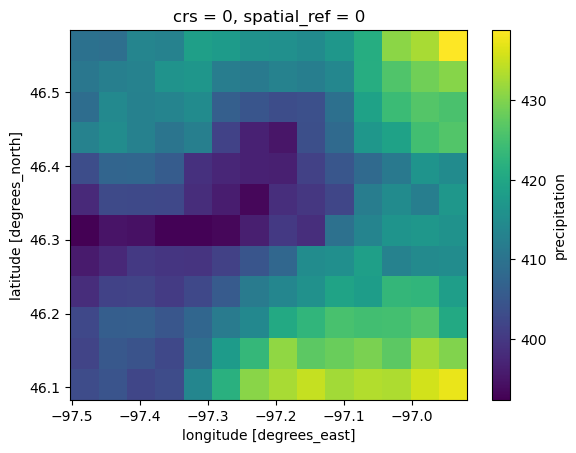

In [307]:
habitat1_maca_2021_original_da = (
    maca_df
    [(maca_df.start_year==2021) & (maca_df.variable=='pr') & (maca_df.site_names=='Sheyenne National Grassland')]
    .da.values[0]
    .rio.write_crs(4326)
    .rio.set_spatial_dims('lat','lon')
    .groupby('time.year')
    .sum()
    .min('year')
)

habitat1_maca_2021_original_da.plot()

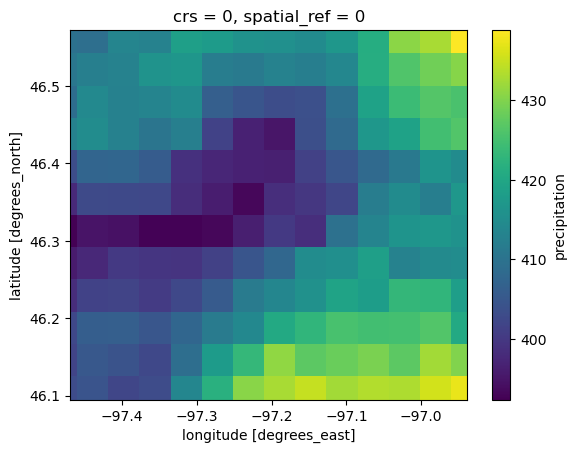

In [308]:
# Reproject data 

habitat1_maca_2021_da = habitat1_maca_2021_original_da.rio.reproject_match(srtm_da)
habitat1_maca_2021_da.plot()

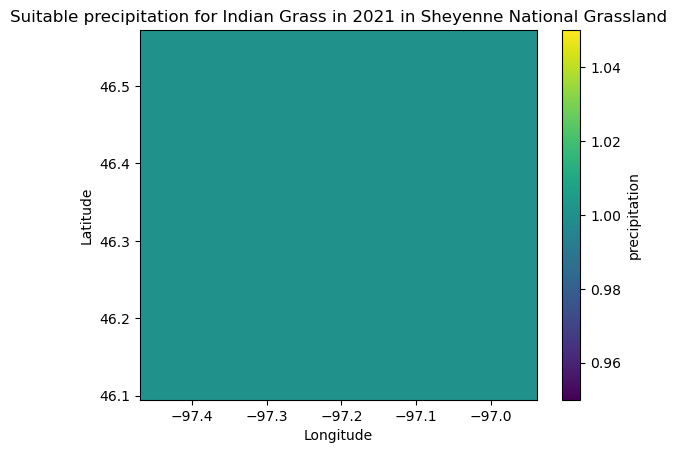

In [309]:
# Check suitability range: between 280 mm/year and 1140 mm/year
habitat1_maca_suitable_2021 = (habitat1_maca_2021_da >= 280) & (habitat1_maca_2021_da <= 1140)

# Plot the result
habitat1_maca_suitable_2021.plot()
plt.title("Suitable precipitation for Indian Grass in 2021 in Sheyenne National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()




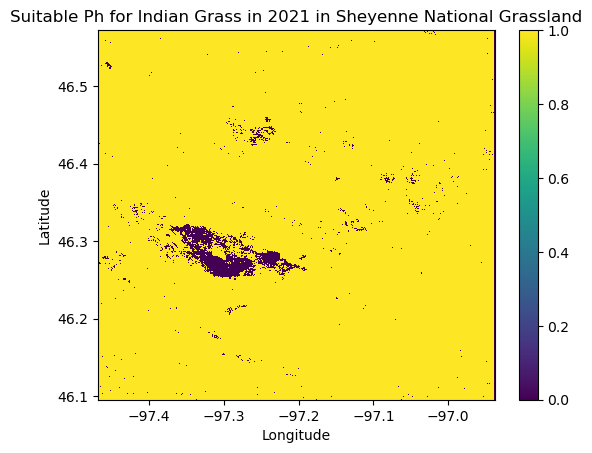

<xarray.DataArray (y: 1717, x: 1911)> Size: 3MB
array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False]])
Coordinates:
  * x            (x) float64 15kB -97.47 -97.47 -97.47 ... -96.94 -96.94 -96.94
  * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [310]:
# Plot suitable soil locations for indian grass based on ph.

habitat1_soil1_suitable_original_2021 = (soil1_merged_das >= 4.8) & (soil1_merged_das <= 8.0)

# Plot the result
habitat1_soil1_suitable_original_2021.plot()
plt.title("Suitable Ph for Indian Grass in 2021 in Sheyenne National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

habitat1_soil1_suitable_original_2021

In [219]:
# Align datasets to the first dataset
aligned_srtm = srtm_suitable_da_numeric.rio.reproject_match(habitat1_maca_suitable_2021_numeric)
aligned_soil = habitat1_soil1_suitable_2021_numeric.rio.reproject_match(habitat1_maca_suitable_2021_numeric)

# Combine the aligned datasets
habitat1_suitable_2021 = (
    habitat1_maca_suitable_2021_numeric & aligned_srtm & aligned_soil
)

In [220]:
# Convert back to boolean for further processing
habitat1_suitable_2021 = habitat1_suitable_2021.astype(bool)


In [222]:
# Check shapes
print("MACA Shape:", habitat1_maca_suitable_2021_numeric.shape)
print("Aligned SRTM Shape:", aligned_srtm.shape)
print("Aligned Soil Shape:", aligned_soil.shape)

# Ensure overlapping values
print("Combined Overlap Sum:", habitat1_suitable_2021.sum().item())


MACA Shape: (1718, 1910)
Aligned SRTM Shape: (1718, 1910)
Aligned Soil Shape: (1718, 1910)
Combined Overlap Sum: 0


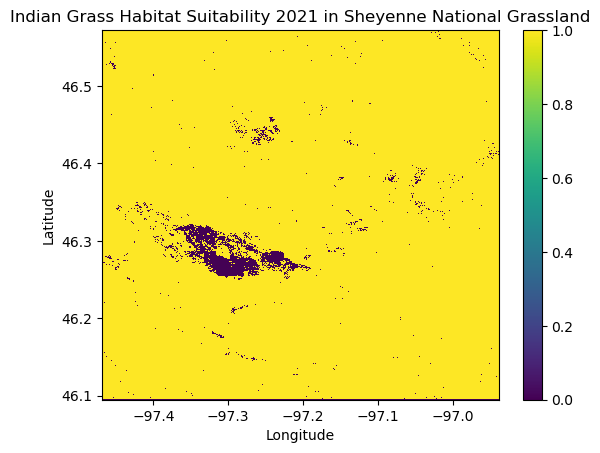

In [258]:
# Combine suitable areas into a boolean array
habitat1_suitable_2021 = habitat1_maca_suitable_2021_numeric & aligned_srtm & aligned_soil
habitat1_suitable_2021.plot()

# # Plot the numeric data
plt.title("Indian Grass Habitat Suitability 2021 in Sheyenne National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Combination and analysis of the data for Sheyenne National Grassland in the year 2076

In [273]:
# Select a specific row of the data frame
habitat1_maca_2076_df = maca_df[(maca_df.start_year==2076) & (maca_df.variable=='pr') & (maca_df.site_names=='Sheyenne National Grassland')].da.values[0]

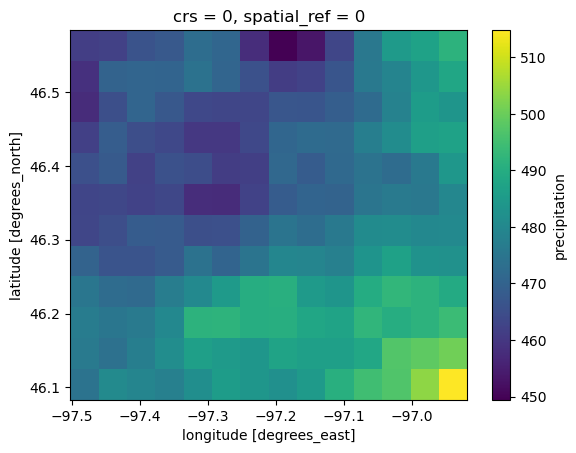

In [276]:
habitat1_maca_2076_original_da = (
    maca_df
    [(maca_df.start_year==2076) & (maca_df.variable=='pr') & (maca_df.site_names=='Sheyenne National Grassland')]
    .da.values[0]
    .rio.write_crs(4326)
    .rio.set_spatial_dims('lat','lon')
    .groupby('time.year')
    .sum()
    .min('year')
)

habitat1_maca_2076_original_da.plot()

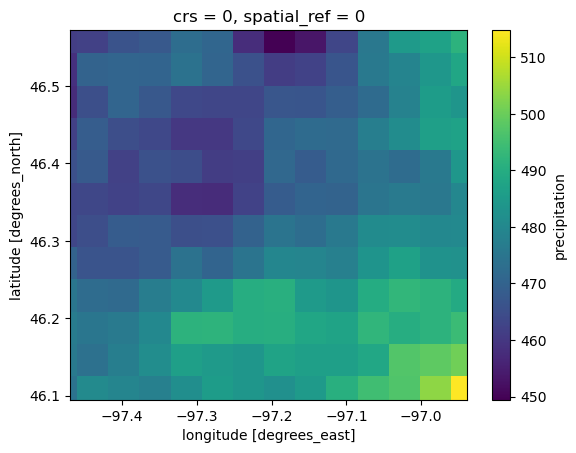

In [277]:
# Reproject data to match elevation 

habitat1_maca_2076_da = habitat1_maca_2076_original_da.rio.reproject_match(srtm_da)
habitat1_maca_2076_da.plot()

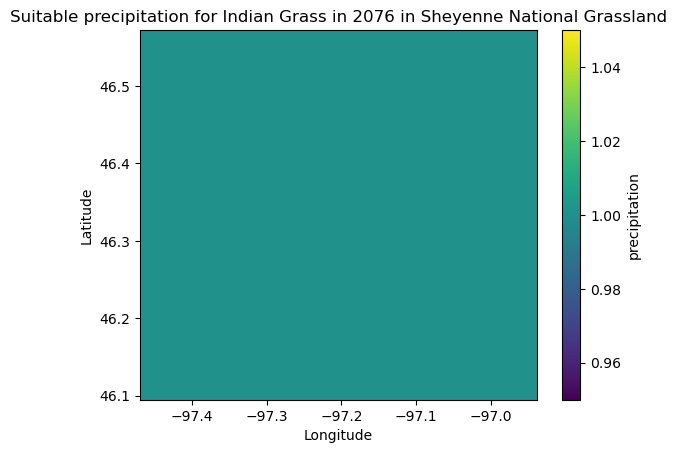

In [278]:
# Check suitability range: between 280 mm/year and 1140 mm/year
habitat1_maca_suitable_2076 = (habitat1_maca_2076_da >= 280) & (habitat1_maca_2076_da <= 1140)

# Plot the result
habitat1_maca_suitable_2076.plot()
plt.title("Suitable precipitation for Indian Grass in 2076 in Sheyenne National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

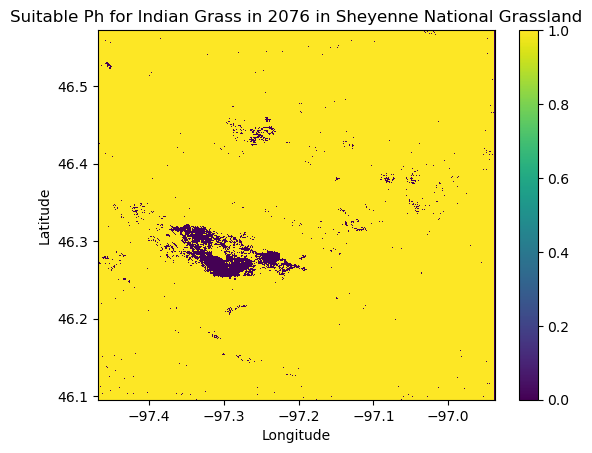

<xarray.DataArray (y: 1717, x: 1911)> Size: 3MB
array([[ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True, False]])
Coordinates:
  * x            (x) float64 15kB -97.47 -97.47 -97.47 ... -96.94 -96.94 -96.94
  * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [279]:
# Plot suitable soil locations for indian grass based on ph - for 2076.

habitat1_soil1_suitable_original_2076 = (soil1_merged_das >= 4.8) & (soil1_merged_das <= 8.0)

# Plot the result
habitat1_soil1_suitable_original_2076.plot()
plt.title("Suitable Ph for Indian Grass in 2076 in Sheyenne National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

habitat1_soil1_suitable_original_2076

## Analysis of habitat suitabiity for Yellow Indian Grass in Sheyenne National Grassland between 2021 and 2076 based on a climate projection of RCP 8.5.

Between the years of 2021 and 2076, the area of Sheyenne National Grassland will get dryer. However, Yellow Indian Grass has a wide ranges of moisture tolereance and this variation is still well within the tolerable level. The only areas where this grass will likely not survive is in areas of unsuitable Ph. There is not yet a way to determine future Ph, so I am unable to tell if this variable would  change in future scenarios. 

If time constrains were not a problem, I would go on to check minimum and maximum temperatures for the area in the future. Yellow Indian Grass goes dormant in temperatures over 100 degrees F and below 60 degrees F - this would be a good indicator if the grass would thrive in changed temperature conditions. 

# Combination and analysis of the data for Little Missouri National Grassland in the year 2021

In [280]:
# Select a specific row of the data frame
habitat2_maca_2021_df = maca_df[(maca_df.start_year==2021) & (maca_df.variable=='pr') & (maca_df.site_names=='Little Missouri National Grassland')].da.values[0]

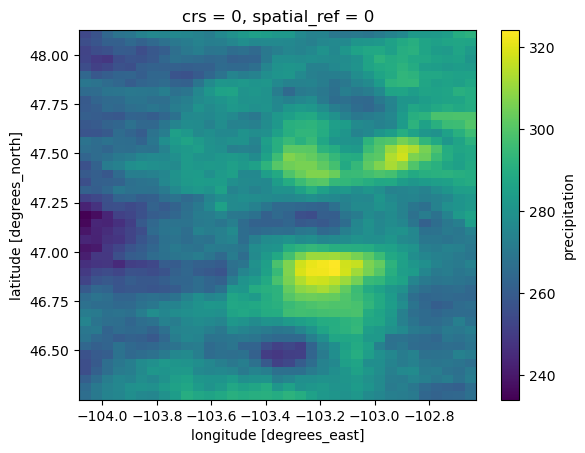

In [299]:
habitat2_maca_2021_original_da = (
    maca_df
    [(maca_df.start_year==2021) & (maca_df.variable=='pr') & (maca_df.site_names=='Little Missouri National Grassland')]
    .da.values[0]
    .rio.write_crs(4326)
    .rio.set_spatial_dims('lat','lon')
    .groupby('time.year')
    .sum()
    .min('year')
)

habitat2_maca_2021_original_da.plot()

<xarray.DataArray (y: 1718, x: 1910)> Size: 13MB
array([[323., 323., 324., ..., 285., 285., 285.],
       [323., 324., 324., ..., 285., 285., 284.],
       [325., 325., 324., ..., 285., 285., 284.],
       ...,
       [360., 360., 359., ..., 331., 332., 332.],
       [358., 357., 357., ..., 328., 330., 329.],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)
Coordinates:
  * x            (x) float64 15kB -97.47 -97.47 -97.47 ... -96.94 -96.94 -96.94
  * y            (y) float64 14kB 46.57 46.57 46.57 46.57 ... 46.1 46.1 46.1
    band         int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Point
    units:          m
    _FillValue:     nan


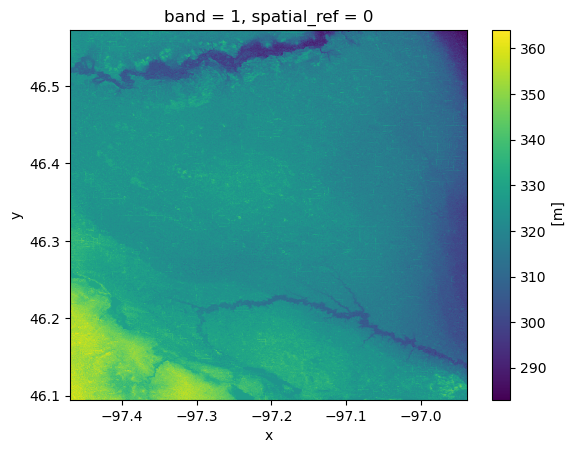

In [325]:
print(srtm_da)
srtm_da.plot()

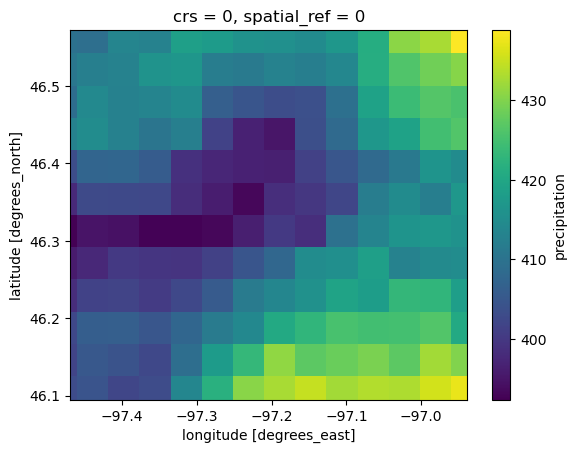

In [315]:
# Reproject data to match elevation 

habitat2_maca_2021_da = habitat1_maca_2021_original_da.rio.reproject_match(srtm_da)
habitat2_maca_2021_da.plot()

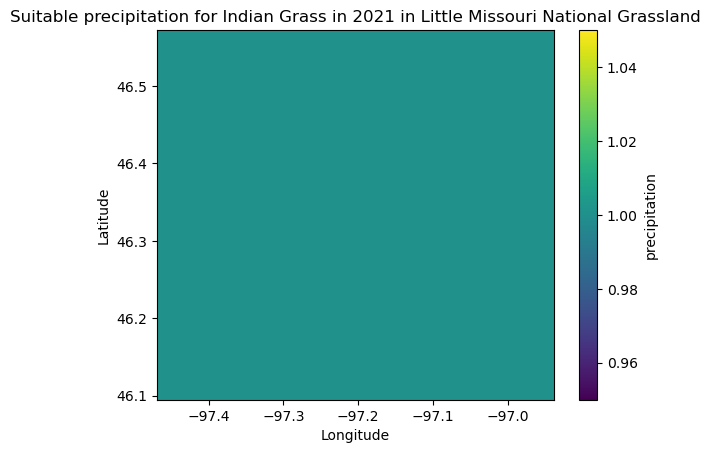

In [317]:
# Check suitability range: between 280 mm/year and 1140 mm/year
habitat2_maca_suitable_2021 = (habitat2_maca_2021_da >= 280) & (habitat2_maca_2021_da <= 1140)

# Plot the result
habitat2_maca_suitable_2021.plot()
plt.title("Suitable precipitation for Indian Grass in 2021 in Little Missouri National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

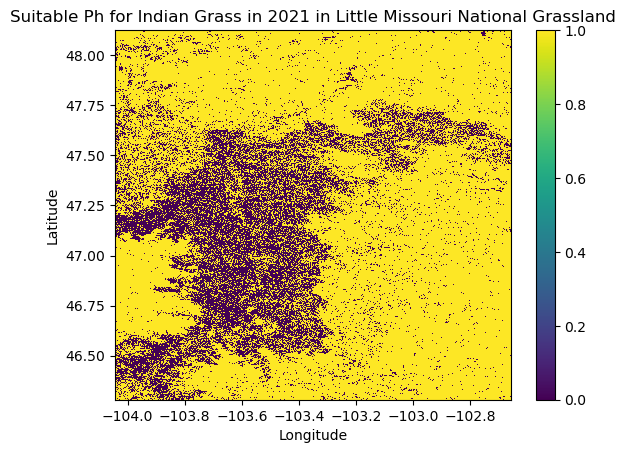

<xarray.DataArray (y: 6643, x: 5006)> Size: 33MB
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * x            (x) float64 40kB -104.0 -104.0 -104.0 ... -102.7 -102.7 -102.7
  * y            (y) float64 53kB 48.13 48.12 48.12 48.12 ... 46.28 46.28 46.28
    band         int64 8B 1
    spatial_ref  int64 8B 0

In [318]:
# Plot suitable soil locations for indian grass based on ph. in Little Missouri National Grassland

habitat2_soil2_suitable_original_2021 = (soil2_merged_das >= 4.8) & (soil2_merged_das <= 8.0)

# Plot the result
habitat2_soil2_suitable_original_2021.plot()
plt.title("Suitable Ph for Indian Grass in 2021 in Little Missouri National Grassland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

habitat2_soil2_suitable_original_2021

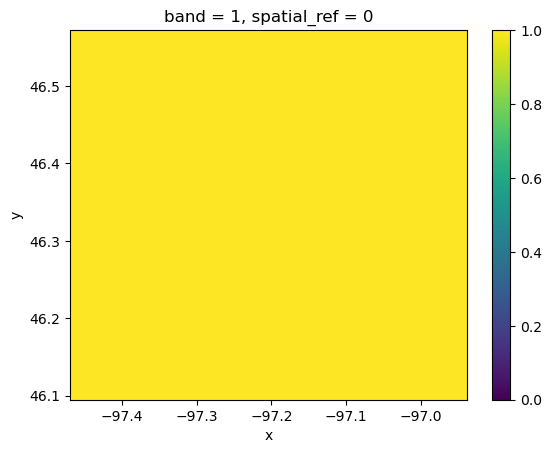

In [321]:
# Plot the elevation data and see if it is suitable for Yellow Indian Grass. 
# I realize now that this was a poor variable to select given that Yellow Indian 
# Grass is suitable for an extremely wide range of elevation - and that climate change won't alter its elevation.

srtm_suitable_da = srtm_da < 5000
srtm_suitable_da.plot()

In [ ]:
# Convert boolean DataArrays to integers
srtm_suitable_da_numeric = srtm_suitable_da.astype("int32")
habitat2_maca_suitable_2021_numeric = habitat2_maca_suitable_2021.astype("int32")
habitat2_soil2_suitable_2021_numeric = habitat2_soil2_suitable_2021.astype("int32")

In [ ]:
# Align datasets to the first dataset
aligned_srtm = srtm_suitable_da_numeric.rio.reproject_match(habitat2_maca_suitable_2021_numeric)
aligned_soil2 = habitat2_soil2_suitable_2021_numeric.rio.reproject_match(habitat2_maca_suitable_2021_numeric)

# Combine the aligned datasets
habitat2_suitable_2021 = (
    habitat2_maca_suitable_2021_numeric & aligned_srtm & aligned_soil2
)

In [ ]:
# How I would finish if I had time

# Determine and plot the precipitation for the Little Missouri National Grassland 

# Determine and plot the Ph for the Little Missouri National Grasslands

# Consider slope and elevation (which seems not to be a serious issues with this species as it is very tough)

# Merge the layers so that you get an idea of habitat suitibility.